<a href="https://colab.research.google.com/github/minz1337/CS114.M11/blob/main/source%20code/Train_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
import sys
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
from keras.regularizers import L1L2
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM,Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import tensorflow

# Read data & prepare

# Model

In [ ]:
#regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
def LSTM_base(input_shape):
  model = Sequential()
  model.add(LSTM (units=100, input_shape=input_shape, return_sequences=True,
                  activity_regularizer=L1L2(l1=0.0, l2=0.01)
                  )) 
  #model.add(Bidirectional(LSTM(100, 
  #      implementation = 2, recurrent_activation = 'sigmoid'),
  #      input_shape=input_shape))
  model.add(Dropout(0.6))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
  return model

def LSTM_FullyConnected(input_shape):
  model = Sequential()
  model.add(LSTM(units=128, activation='sigmoid', input_shape=input_shape,return_sequences=True))
  model.add(Dropout(0.1))
  model.add(Dense(64))
  model.add(Dropout(0.1))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  return model

def LSTM_stacked(input_shape):
  model = Sequential()
  model.add(LSTM(units=50, activation='relu', input_shape=input_shape, return_sequences=True))
  model.add(Dropout(0.3))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.3))

  model.add(LSTM(units=50))
  model.add(Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  return model

In [ ]:
def summarize_loss(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Train Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import numpy as np
from tqdm import tqdm
import math
import os
# read dataa= train
dataset1 = h5py.File('/content/drive/MyDrive/CS114.M11/DOANCK/dataset/Feature/Train_highlight', 'r')
dataset2 = h5py.File('/content/drive/MyDrive/CS114.M11/DOANCK/dataset/Feature/Train_non_highlight', 'r')
dataset3 = h5py.File('/content/drive/MyDrive/CS114.M11/DOANCK/dataset/Feature/Train_highlight1', 'r')

In [ ]:
import torch
X_train=[]
y_train=[]
for key in dataset1.keys():
  seq = dataset1[key]['features'][...] # sequence of features, (seq_len, dim)
  if seq.shape == (20,2048):
    X_train.append(seq) # input shape (seq_len, dim)
    y_train.append(1) # label

In [ ]:
for key in dataset2.keys():
  seq = dataset2[key]['features'][...]
  if seq.shape == (20,2048): # sequence of features, (seq_len, dim)
    X_train.append(seq) # input shape ( seq_len, dim)
    y_train.append(0) #label

In [ ]:
for key in dataset3.keys():
  seq = dataset3[key]['features'][...] # sequence of features, (seq_len, dim)
  if seq.shape == (20,2048):
    X_train.append(seq) # input shape ( seq_len, dim)
    y_train.append(1) # label

In [ ]:
y_train=np.array(y_train).reshape(len(y_train),-1) # reshape (sample , label)
X_train=np.array(X_train) 

In [ ]:
import tensorflow as tf
# shuffle data
indices = tf.range(start=0, limit=y_train.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

y_train = tf.gather(y_train, shuffled_indices)
X_train = tf.gather(X_train, shuffled_indices)

In [ ]:
X_train.shape , y_train.shape

(TensorShape([1726, 20, 2048]), TensorShape([1726, 1]))

## data test

In [ ]:
# read data test
dataset4 = h5py.File('/content/drive/MyDrive/CS114.M11/DOANCK/dataset/Feature/test-hl', 'r')
dataset5 = h5py.File('/content/drive/MyDrive/CS114.M11/DOANCK/dataset/Feature/test-non', 'r')

In [ ]:
X_test=[]
y_test=[]
for key in dataset4.keys():
  seq = dataset4[key]['features'][...] # sequence of features, (seq_len, dim)
  if seq.shape == (20,2048):
    X_test.append(seq) # input shape (seq_len, dim)
    y_test.append(1)

In [ ]:
for key in dataset5.keys():
  seq = dataset5[key]['features'][...] # sequence of features, (seq_len, dim)
  if seq.shape == (20,2048):
    X_test.append(seq) # input shape (seq_len, dim)
    y_test.append(0)

In [ ]:
y_test=np.array(y_test).reshape(len(y_test),-1)
X_test=np.array(X_test)

In [ ]:
X_test.shape , y_test.shape

((264, 20, 2048), (264, 1))

## Train

In [ ]:
import tensorflow as tf
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/LSTM.h5',
                                       monitor='val_loss',
                                       verbose=1, 
                                       save_weight_only=True,
                                       save_best_only=True,
                                       mode='min')
]

In [ ]:
model = LSTM_base((20,2048)) # init model
model.summary()
#fit newtwork
epochs=30
history = model.fit(X_train, y_train, validation_split=0.2,
                      epochs=epochs,
                      callbacks=callbacks
                    )


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 100)           859600    
                                                                 
 dropout_1 (Dropout)         (None, 20, 100)           0         
                                                                 
 dense_1 (Dense)             (None, 20, 1)             101       
                                                                 
Total params: 859,701
Trainable params: 859,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
43/44 [============================>.] - ETA: 0s - loss: 1.1734 - accuracy: 0.6547
Epoch 00001: val_loss did not improve from 0.47662
44/44 [==============================] - 7s 104ms/step - loss: 1.1718 - accuracy: 0.6549 - val_loss: 0.6930 - val_accuracy: 0.6618
Epoch 2/30
43/44 [==================

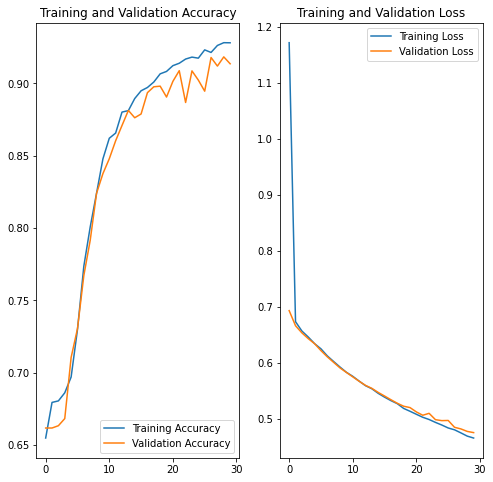

In [ ]:
summarize_loss(history, epochs) # plot result

In [ ]:
model = tensorflow.keras.models.load_model(filepath="/content/LSTM.h5")

In [ ]:
model.evaluate(X_test,y_test) # evaluate by data test

9/9 [==============================] - 0s 34ms/step - loss: 0.8411 - accuracy: 0.5047


[0.8410683870315552, 0.5047348737716675]